### Load libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import joblib
import re
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Important for combining SMOTE with other steps
import spacy
from tqdm import tqdm
from src.utils import *

## 1) Data

In [2]:
pickle_file_path = 'data/results/catalog_nouns_500k.pkl'
catalog_fin = pd.read_pickle(pickle_file_path)
catalog_fin.head(2)

,product_id,quality_status,manufacturer_name,manufacturer_pid,model,short_description,long_description,additional_description,noun,norm,scope,site,cleaned_noun,category_noun,matched_noun
0,101050487,SPARROW_APPROVED,CKD,SCM-FA-20B-100-T3H3-D-Z-6,SCM-FA-20B-100-T3H3-D-Z-6,air cylinder,NaN,NaN,cylinder,NaN,In,YA2Z Shiga,cylinder,"Valves, Actuator, Fittings",cylinder
1,101050486,SPARROW_APPROVED,CKD,SCM-TA-25B-50-T3H3-D-B2-6,SCM-TA-25B-50-T3H3-D-B2-6,air cylinder,NaN,NaN,cylinder,NaN,In,YA2Z Shiga,cylinder,"Valves, Actuator, Fittings",cylinder


In [3]:
catalog_fin[['cleaned_noun', 'category_noun']]

,cleaned_noun,category_noun
0,cylinder,"Valves, Actuator, Fittings"
1,cylinder,"Valves, Actuator, Fittings"
2,cylinder,"Valves, Actuator, Fittings"
3,cylinder,"Valves, Actuator, Fittings"
4,cylinder,"Valves, Actuator, Fittings"
...,...,...
481121,rodamiento,Fasteners
481122,rillenkugellager,Fasteners
481123,pendelkugellager,Fasteners
481124,rodamiento,Fasteners


In [4]:
catalog_fin.shape

(382819, 15)

In [5]:
unique_values = catalog_fin['cleaned_noun'].nunique()
print(f"Number of unique values in 'cleaned_noun': {unique_values}")

Number of unique values in 'cleaned_noun': 38500


In [6]:
nan_values = catalog_fin['cleaned_noun'].isna().sum()
print(f"Number of NaN values in 'cleaned_noun': {nan_values}")

Number of NaN values in 'cleaned_noun': 0


In [7]:
catalog_fin[catalog_fin['cleaned_noun']=='tee'].head(2)

,product_id,quality_status,manufacturer_name,manufacturer_pid,model,short_description,long_description,additional_description,noun,norm,scope,site,cleaned_noun,category_noun,matched_noun
8152,101042333,SPARROW_PROCESSING,NMS - Not Manufacturer Specific,3104-62-00,NaN,"UNION TEE, 1/2 OD X 1/2 OD",NaN,NaN,TEE,NaN,In,J1CF Indianola,tee,None,None
8242,101042240,SPARROW_PROCESSING,"Aurora Air Products, Inc.",3GD02,3GD02,"TEE, 1/4 INCH SAE SWIVEL TEE WITH CORE DEPRESS...",NaN,NaN,TEE,NaN,In,J1CF Indianola,tee,None,None


In [8]:
catalog_fin['word_count'] = catalog_fin['noun'].apply(count_words)

In [9]:
catalog_fin.word_count.describe()

count    382819.000000
mean          1.132465
std           0.414414
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: word_count, dtype: float64

In [10]:
catalog_fin.word_count.value_counts()

word_count
1    341033
2     34448
3      6048
4      1047
5       204
6        28
7         8
8         3
Name: count, dtype: int64

In [11]:
# catalog_short = catalog_fin[catalog_fin['word_count'].isin([1, 8])]
# catalog_short.shape

In [12]:
# catalog_short=catalog_fin

Most of the records in noun column have just one word. In our case let's first take 1 and 2 words cases

In [13]:
catalog_fin['category_noun'].value_counts()

category_noun
Fasteners                                    130127
Electrical Installation Materials, device     45340
Valves, Actuator, Fittings                    36984
Gas, water and sewage installation            26040
Piping Materials                              20184
Facility consumables                          10907
Equipment OEM Spare Parts                      5170
Name: count, dtype: int64

In [14]:
# List of categories with matched and matched nouns
categories_to_filter = ["Fasteners", "Gas, water and sewage installation", "Electrical Installation Materials, device", "Piping Materials", 
                        "Valves, Actuator, Fittings", "Facility consumables", "Equipment OEM Spare Parts"]

filtered_df_noun = catalog_fin[catalog_fin['category_noun'].isin(categories_to_filter)]
filtered_df_noun = filtered_df_noun[['cleaned_noun', 'category_noun']]
non_matched_df = catalog_fin[~catalog_fin['category_noun'].isin(categories_to_filter)]

In [15]:
# non_matched_df.to_pickle('data/results/non_matched_nouns.pkl')

In [16]:
print(filtered_df_noun.shape)
print(catalog_fin.shape)
percentage = (filtered_df_noun.shape[0] / catalog_fin.shape[0]) * 100
print(f'Percentage = {percentage:.2f}%')

(274752, 2)
(382819, 16)
Percentage = 71.77%


In [17]:
filtered_df_noun.cleaned_noun.describe()

count     274752
unique     14256
top        oring
freq       11607
Name: cleaned_noun, dtype: object

In [18]:
# filtered_df_noun.to_pickle('results\matched_values.pkl')

## 2) Build the model

### 2.1) Tfidf and Logistic Regression model

In [66]:
# filtered_df['cleaned_noun'] = filtered_df['cleaned_noun'].str.lower()
X = filtered_df_noun['cleaned_noun']  # Features (cleaned nouns)
y = filtered_df_noun['category_noun']  # Labels (categories)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = make_pipeline(TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95), LogisticRegression(max_iter=1000))    # Pipeline
model.fit(X_train, y_train)

y_pred = model.predict(X_test)  # Evaluate
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

Electrical Installation Materials, device       1.00      0.98      0.99      6834
                Equipment OEM Spare Parts       0.98      0.98      0.98       765
                     Facility consumables       1.00      0.97      0.98      1677
                                Fasteners       0.99      1.00      0.99     19434
       Gas, water and sewage installation       1.00      0.99      0.99      3893
                         Piping Materials       1.00      0.99      1.00      3033
               Valves, Actuator, Fittings       1.00      0.99      1.00      5577

                                 accuracy                           0.99     41213
                                macro avg       0.99      0.99      0.99     41213
                             weighted avg       0.99      0.99      0.99     41213



Save the models

In [69]:
joblib.dump(model, 'models/text_classification_model_full_catalog.joblib')

['models/text_classification_model_full_catalog.joblib']

Explaining the model. Obtaining coefficients for most important words

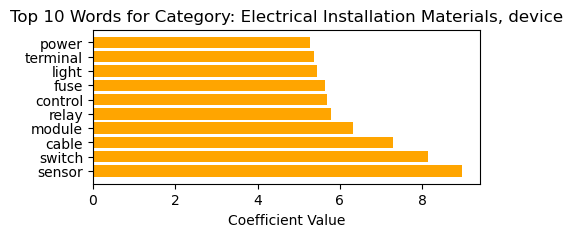

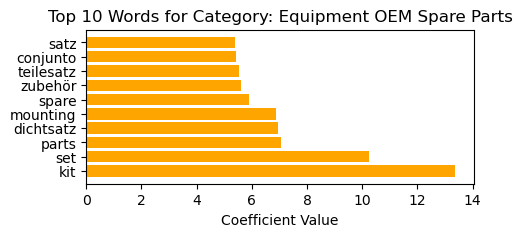

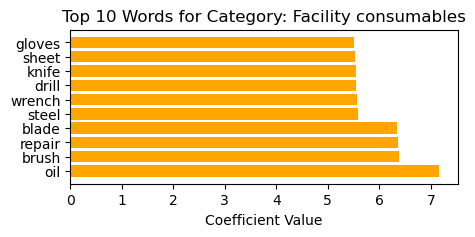

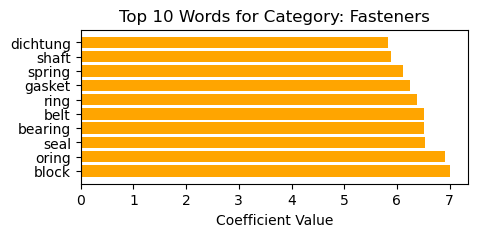

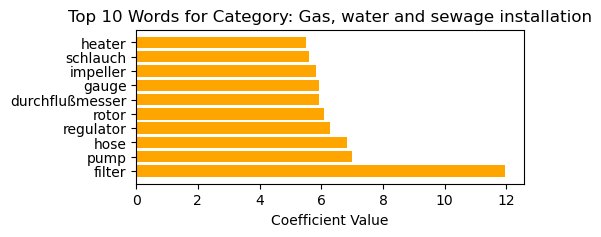

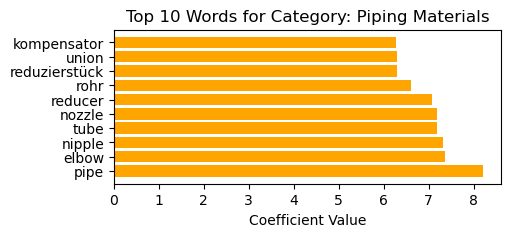

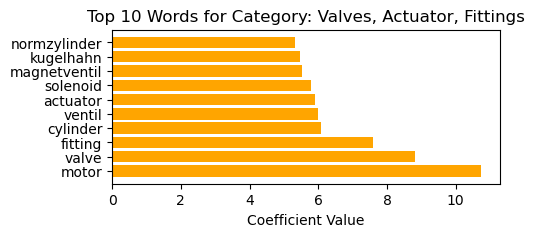

In [70]:
vectorizer = model.named_steps['tfidfvectorizer']
log_reg = model.named_steps['logisticregression']
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = log_reg.coef_

# We sort the words by its coefficients inside every category
for i, category in enumerate(log_reg.classes_):
    sorted_indices = coefficients[i].argsort()
    
    top_words = feature_names[sorted_indices[-10:]]    # 10 most important words
    top_coeffs = coefficients[i][sorted_indices[-10:]]
    
    plt.figure(figsize=(5, 2))
    plt.barh(top_words, top_coeffs, color='orange')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Words for Category: {category}')
    plt.gca().invert_yaxis() 
    plt.show()

Plotting results for the test dataset

In [71]:
X_test

347020             filter
29901              gasket
405840    wellendichtring
308164              oring
217051               pipe
               ...       
212495            bushing
335522          indicator
371074            adapter
193726            breaker
476410            valvula
Name: cleaned_noun, Length: 41213, dtype: object

#### Run for the test dataset

In [72]:
# Apply it to the test dataset
probabilities = model.predict_proba(X_test)
probabilities_df = pd.DataFrame(probabilities, columns=model.classes_)
probabilities_df = probabilities_df.round(2)
# probabilities_df['cleaned_noun'] = X_test
probabilities_df['max_probability'] = probabilities_df.max(axis=1)
probabilities_df['predicted_category'] = probabilities_df.idxmax(axis=1)
probabilities_df['cleaned_noun']= X_test.values

In [73]:
probabilities_df.sort_values(by='max_probability', ascending=True)

,"Electrical Installation Materials, device",Equipment OEM Spare Parts,Facility consumables,Fasteners,"Gas, water and sewage installation",Piping Materials,"Valves, Actuator, Fittings",max_probability,predicted_category,cleaned_noun
21377,0.22,0.10,0.07,0.18,0.17,0.05,0.20,0.22,"Electrical Installation Materials, device",air maintenance unit
3943,0.24,0.18,0.08,0.24,0.10,0.04,0.11,0.24,"Electrical Installation Materials, device",dichtungsset
31704,0.21,0.02,0.07,0.22,0.09,0.28,0.10,0.28,Piping Materials,spaltrohr
24352,0.21,0.02,0.07,0.22,0.09,0.28,0.10,0.28,Piping Materials,rückströmsicherung
5231,0.21,0.02,0.07,0.22,0.09,0.28,0.10,0.28,Piping Materials,spaltrohr
...,...,...,...,...,...,...,...,...,...,...
18809,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,Fasteners,shaft
18807,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,Fasteners,adapter
18805,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,Fasteners,oring
18823,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,Fasteners,disc


In [74]:
probabilities_df.max_probability.describe()

count    41213.000000
mean         0.966462
std          0.083062
min          0.220000
25%          0.980000
50%          0.990000
75%          1.000000
max          1.000000
Name: max_probability, dtype: float64

#### Run for unmatched values

In [75]:
# Apply it to the unmatched values
loaded_model = joblib.load('models/text_classification_model_full_catalog.joblib')
new_data = non_matched_df['cleaned_noun'].tolist()  # Replace with your actual new data
probabilities = loaded_model.predict_proba(new_data)
probabilities_df = pd.DataFrame(probabilities, columns=loaded_model.classes_)
probabilities_df = probabilities_df.round(2)
probabilities_df['max_probability'] = probabilities_df.max(axis=1)
probabilities_df['predicted_category'] = probabilities_df.idxmax(axis=1)
probabilities_df['cleaned_noun'] = new_data

In [76]:
probabilities_df

,"Electrical Installation Materials, device",Equipment OEM Spare Parts,Facility consumables,Fasteners,"Gas, water and sewage installation",Piping Materials,"Valves, Actuator, Fittings",max_probability,predicted_category,cleaned_noun
0,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,höinrodd
1,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,スüßbürz
2,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,スüßbürz
3,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,スüßbema
4,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,белрт
...,...,...,...,...,...,...,...,...,...,...
108062,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,carrilera
108063,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,tapas
108064,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,columna
108065,0.33,0.02,0.07,0.35,0.09,0.03,0.11,0.35,Fasteners,rollo


In [77]:
probabilities_df.max_probability.describe()  # Very low values for the maximum probability

count    108067.000000
mean          0.371746
std           0.070638
min           0.210000
25%           0.350000
50%           0.350000
75%           0.350000
max           0.890000
Name: max_probability, dtype: float64

In [78]:
probabilities_df.predicted_category.value_counts()  # Very low values for the maximum probability

predicted_category
Fasteners                                    97240
Electrical Installation Materials, device     8969
Gas, water and sewage installation            1444
Valves, Actuator, Fittings                     352
Facility consumables                            31
Piping Materials                                31
Name: count, dtype: int64

In [79]:
# Check the number of NaN values in the 'cleaned_noun' column
nan_values = non_matched_df['cleaned_noun'].isna().sum()
print(f"Number of NaN values in 'cleaned_noun': {nan_values}")

Number of NaN values in 'cleaned_noun': 0


#### Save 100 most common nouns from the unmatched values

In [80]:
probabilities_df.cleaned_noun.value_counts().head(30)

cleaned_noun
tee              2265
assembly         1839
plug             1469
cover            1290
board             783
bar               716
element           701
rod               633
insert            484
stud              441
tstück            401
panel             385
tape              382
wire              377
vflansch          375
gummi             364
cross             361
holder            354
coil              352
body              351
xmtr              342
dichtungclamp     341
parafuso          340
bag               332
box               332
head              325
anel              312
strainer          312
face              299
glass             247
Name: count, dtype: int64

In [81]:
# Most common nouns and export it to Excel
top_100_nouns = probabilities_df['cleaned_noun'].value_counts().head(100)
top_100_nouns_df = top_100_nouns.reset_index()
top_100_nouns_df.columns = ['noun', 'count']  # Rename columns for clarity
# top_100_nouns_df.to_excel('top_100_nouns.xlsx', index=False)

#### Run for Adams 1k parts

In [82]:
df_mil=pd.read_csv('data/1k_Parts/BAYER_mat_group_flags_20241206_1k‑verified_20241210.csv')
df_mil = df_mil.dropna(subset=['noun'])  # Some NaN values at the end
df_mil['cleaned_noun'] = df_mil['noun'].apply(clean_category_text)

In [83]:
df_mil['qa_label'].value_counts()

qa_label
Fasteners                                    330
Electrical Installation Materials, device    190
Valves, Actuator, Fittings                   157
Equipment OEM Spare Parts                    121
Gas, water and sewage installation            96
Piping Materials                              67
Facility consumables                          27
Name: count, dtype: int64

In [ ]:
df_mil[df_mil['']]

In [85]:
loaded_model = joblib.load('models/text_classification_model_full_catalog.joblib')
new_data = df_mil['cleaned_noun'].tolist()
probabilities = loaded_model.predict_proba(new_data)
probabilities_df = pd.DataFrame(probabilities, columns=loaded_model.classes_)
probabilities_df = probabilities_df.round(2)
df_mil['max_probability'] = probabilities_df.max(axis=1)
df_mil['predicted_category'] = probabilities_df.idxmax(axis=1)

In [86]:
# Compute the metrics
df_mil['qa_label'] = df_mil['qa_label'].astype(str)
df_mil['predicted_category'] = df_mil['predicted_category'].astype(str)
accuracy = accuracy_score(df_mil['qa_label'], df_mil['predicted_category'])
report = classification_report(df_mil['qa_label'], df_mil['predicted_category'])
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.60

Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.61      0.55      0.58       190
                Equipment OEM Spare Parts       0.62      0.04      0.08       121
                     Facility consumables       0.41      0.41      0.41        27
                                Fasteners       0.62      0.89      0.73       330
       Gas, water and sewage installation       0.44      0.50      0.47        96
                         Piping Materials       0.66      0.55      0.60        67
               Valves, Actuator, Fittings       0.64      0.58      0.61       157
                                      nan       0.00      0.00      0.00         0

                                 accuracy                           0.60       988
                                macro avg       0.50      0.44      0.43       988
                             weighted avg     

c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
df_mil.to_pickle('df_mil_tfidf.pkl')

In [59]:
df_mil.qa_label.value_counts()

qa_label
Fasteners                                    330
Electrical Installation Materials, device    190
Valves, Actuator, Fittings                   157
Equipment OEM Spare Parts                    121
Gas, water and sewage installation            96
Piping Materials                              67
Facility consumables                          27
Name: count, dtype: int64

In [48]:
df_mil[df_mil['qa_label']=='Equipment OEM Spare Parts']

,Product Id,Quality Status,Manufacturer Name,Manufacturer PID,model,Short Description,Long Description,Additional description,score,Product family,...,script_helper,mfr_helper,noun_helper,mfr noun result match,qa_group,qa_label,review,cleaned_noun,max_probability,predicted_category
7,101039312,SPARROW_PROCESSING,"ATS sortimat USA, LLC",662539,NaN,"RAIL, GUIDE, RAIL,",NaN,NaN,NaN,NaN,...,True,True,NaN,Null result present,99501340,Equipment OEM Spare Parts,bad string match,rail,0.96,Fasteners
14,61869560,SPARROW_PROCESSING,Tectrion,NaN,NaN,ausl.Becherbodenzentrierung,ausl.Becherbodenzentrierung; TECTRION; Benennu...,Benennung: Becherbodenzentrierung; Hersteller:...,NaN,NaN,...,False,False,NaN,Null result present,99501340,Equipment OEM Spare Parts,cup centering device? Part of a chemical device?,becherbodenzentrierung,0.35,Fasteners
15,61782339,SPARROW_PROCESSING,Kilian,213813,NaN,ANILLO OPRESOR;;213813,ANILLO OPRESOR;;213813; KILIAN_213813; Anillo ...,Anillo opresor para disco,NaN,NaN,...,False,NaN,False,Null result present,99501340,Equipment OEM Spare Parts,Engine device - piston clamp,anillo,0.98,Fasteners
45,61900833,SPARROW_IN_PROGRESS,NaN,120014,120014,"KIT:MOTOR SEAL,120014","KIT:MOTOR SEAL,120014; ; KIT: MOTOR SEAL TYPE,...","KIT: MOTOR SEAL TYPE, 120014 MFG P/N; WHERE AP...",6,NaN,...,False,NaN,False,Null result present,99501340,Equipment OEM Spare Parts,Motor?,kitmotor seal,1.00,"Valves, Actuator, Fittings"
46,62056024,SPARROW_PROCESSING,NaN,NaN,NaN,ANF hydraulic operated motor of SDV,ANF hydraulic operated motor of SDV; ;,NaN,NaN,NaN,...,False,NaN,False,Null result present,99501340,Equipment OEM Spare Parts,Motor?,motor,1.00,"Valves, Actuator, Fittings"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,61861741,SPARROW_PROCESSING,Breitner Abfüllanlagen,129318,NaN,Wellenverlängerung V2A 129318,Wellenverlängerung V2A 129318; BREI...,Benennung: Wellenverlängerung; Werkstoff: V2A;...,NaN,NaN,...,True,True,NaN,Null result present,99501340,Equipment OEM Spare Parts,NaN,wellenverlängerung,0.95,"Gas, water and sewage installation"
975,62038732,SPARROW_PROCESSING,Amixon,10000126,LT24,Widerstandsthermometer LT24 Pt100 170mm,Widerstandsthermometer LT24 Pt100 170mm; AMIXO...,Benennung: Widerstandsthermometer; Typ: LT24; ...,NaN,NaN,...,True,True,NaN,Null result present,99501340,Equipment OEM Spare Parts,NaN,widerstandsthermometer,0.65,"Valves, Actuator, Fittings"
977,62048164,SPARROW_PROCESSING,Pester,115820,NaN,Pester Wrapping machine/washer/373999,Pester Wrapping machine/washer/373999; 115820;,NaN,NaN,NaN,...,True,True,NaN,Null result present,99501340,Equipment OEM Spare Parts,NaN,wrapping machinewasher,0.35,Fasteners
978,62048030,SPARROW_PROCESSING,amixon GmbH,NaN,NaN,Zahnkranz Pos.77,Zahnkranz Pos.77; AMIX...,Benennung: Zahnkranz; für: Getriebe KS 6000.3-...,NaN,NaN,...,True,True,NaN,Null result present,99501340,Equipment OEM Spare Parts,NaN,zahnkranz,0.99,Fasteners


In [38]:
# df_mil.to_csv('df_mil_Adam_prediction.csv')

In [39]:
df_mil.max_probability.describe()

count    1000.000000
mean        0.900670
std         0.195136
min         0.210000
25%         0.930000
50%         0.990000
75%         1.000000
max         1.000000
Name: max_probability, dtype: float64

Get the performance metrics. Specially bad results for OEM, needs to be reviewed.

In [40]:
df_mil['qa_label'] = df_mil['qa_label'].astype(str)  # or 'int' depending on your data type
df_mil['predicted_category'] = df_mil['predicted_category'].astype(str)  # or 'int'
accuracy = accuracy_score(df_mil['qa_label'], df_mil['predicted_category'])
report = classification_report(df_mil['qa_label'], df_mil['predicted_category'])
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.76

Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.88      0.77      0.82       195
                Equipment OEM Spare Parts       1.00      0.07      0.12       121
                     Facility consumables       0.67      0.67      0.67        27
                                Fasteners       0.68      0.99      0.81       335
       Gas, water and sewage installation       0.64      0.72      0.68        97
                         Piping Materials       0.96      0.81      0.88        67
               Valves, Actuator, Fittings       0.87      0.78      0.82       158

                                 accuracy                           0.76      1000
                                macro avg       0.81      0.69      0.69      1000
                             weighted avg       0.80      0.76      0.72      1000



#### Run for 10k random parts

In [42]:
catalog_fin_10k = catalog_fin
catalog_fin_10k['category_noun'] = catalog_fin_10k['category_noun'].fillna('Undefined')

num_categories = catalog_fin_10k['category_noun'].nunique()
samples_per_category = 10000 // num_categories
sampled_df = catalog_fin_10k.groupby('category_noun', group_keys=False).apply(lambda x: x.sample(min(len(x), samples_per_category)))

sampled_df.category_noun.value_counts()

C:\Users\RodrigoMartínezAlons\AppData\Local\Temp\ipykernel_23460\4170353576.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = catalog_fin_10k.groupby('category_noun', group_keys=False).apply(lambda x: x.sample(min(len(x), samples_per_category)))


category_noun
Electrical Installation Materials, device    1250
Equipment OEM Spare Parts                    1250
Facility consumables                         1250
Fasteners                                    1250
Gas, water and sewage installation           1250
Piping Materials                             1250
Undefined                                    1250
Valves, Actuator, Fittings                   1250
Name: count, dtype: int64

In [43]:
sampled_df['cleaned_noun'] = sampled_df['noun'].apply(clean_category_text)

In [68]:
loaded_model = joblib.load('models/text_classification_model_full_catalog.joblib')
new_data = sampled_df['cleaned_noun'].tolist()
probabilities = loaded_model.predict_proba(new_data)
probabilities_df = pd.DataFrame(probabilities, columns=loaded_model.classes_)
probabilities_df = probabilities_df.round(2)

 # Extra steps, otherwise it is not working
sampled_df['max_probability'] = probabilities_df.max(axis=1).tolist()
sampled_df['predicted_category'] = probabilities_df.idxmax(axis=1).tolist()

In [69]:
sampled_df.head(2)

,product_id,quality_status,manufacturer_name,manufacturer_pid,model,short_description,long_description,additional_description,noun,norm,scope,site,cleaned_noun,category_noun,matched_noun,word_count,max_probability,predicted_category
316080,61736265,SPARROW_APPROVED,SCHNEIDER ELECTRIC,LC1D18B7,NaN,Leistungsschütz LC1D 3p +1S+1Ö,"CONTACTOR:MAGNETIC,IEC,24VAC,LC1D18B7; ; CONTA...","CONTACTOR:MAGNETIC,IEC,24VAC,LC1D18B7; TYPE: I...",Schütz,CSA C22.2 No 14;EN 60947-4-1;EN 60947-5-1;IEC ...,NaN,CJJF,schütz,"Electrical Installation Materials, device",schütz,1,0.98,"Electrical Installation Materials, device"
115494,61960796,SPARROW_APPROVED,SCHNEIDER ELECTRIC,LRD16,NaN,Motorschutzrelais 9-13A 1S+1Ö,MRP-O/L RLY LRD-16 9.0-13A TELEMECANIQUE; ;,NaN,Thermisches Überlastrelais mit Differenzialschutz,EN/IEC 60947-4-1;EN/IEC 60947-5-1;UL 60947-4-1...,NaN,KMLG,thermisches überlastrelais mit differenzialschutz,"Electrical Installation Materials, device",überlastrelais,4,0.97,"Electrical Installation Materials, device"


All the undefined are lying in the fasteners category because it is the biggest one. 

Model does not know how to categorize them, and decides to include them into the most common one.

In [51]:
sampled_df.predicted_category.value_counts()

predicted_category
Fasteners                                    2439
Electrical Installation Materials, device    1333
Gas, water and sewage installation           1259
Valves, Actuator, Fittings                   1254
Piping Materials                             1246
Equipment OEM Spare Parts                    1236
Facility consumables                         1233
Name: count, dtype: int64

In [52]:
# sampled_df.to_csv('df_10k_cat.csv')
# sampled_df.to_excel('df_10k_cat.xlsx')

All values for undefining are inside Fasteners

In [64]:
sampled_df['category_noun'] = sampled_df['category_noun'].astype(str)  # or 'int' depending on your data type
sampled_df['predicted_category'] = sampled_df['predicted_category'].astype(str)  # or 'int'
accuracy = accuracy_score(sampled_df['category_noun'], sampled_df['predicted_category'])
report = classification_report(sampled_df['category_noun'], sampled_df['predicted_category'])
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.87

Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.93      0.99      0.96      1250
                Equipment OEM Spare Parts       1.00      0.99      0.99      1250
                     Facility consumables       1.00      0.98      0.99      1250
                                Fasteners       0.51      1.00      0.68      1250
       Gas, water and sewage installation       0.99      0.99      0.99      1250
                         Piping Materials       1.00      1.00      1.00      1250
                                Undefined       0.00      0.00      0.00      1250
               Valves, Actuator, Fittings       1.00      1.00      1.00      1250

                                 accuracy                           0.87     10000
                                macro avg       0.80      0.87      0.83     10000
                             weighted avg     

c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

### 1.2) With the CountVectorizer

In [ ]:
model_count = make_pipeline(CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95), LogisticRegression(max_iter=1000))
model_count.fit(X_train, y_train)
y_pred_count = model_count.predict(X_test)
print("CountVectorizer Model:")
print(classification_report(y_test, y_pred_count))

CountVectorizer Model:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       1.00      0.98      0.99      6834
                Equipment OEM Spare Parts       0.99      0.98      0.98       765
                     Facility consumables       1.00      0.97      0.98      1677
                                Fasteners       0.99      1.00      0.99     19434
       Gas, water and sewage installation       1.00      0.99      0.99      3893
                         Piping Materials       1.00      1.00      1.00      3033
               Valves, Actuator, Fittings       1.00      0.99      0.99      5577

                                 accuracy                           0.99     41213
                                macro avg       0.99      0.99      0.99     41213
                             weighted avg       0.99      0.99      0.99     41213



### 1.3) Adjusting imbalanced classes

1) Inside the Pipeline

In [70]:
X = filtered_df_noun['cleaned_noun']  # Features (cleaned nouns)
y = filtered_df_noun['category_noun']  # Labels (categories)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
model = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95),
    LogisticRegression(max_iter=1000, class_weight='balanced')  # Automatically adjusts weights for imbalanced classes
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.97      0.99      0.98      6834
                Equipment OEM Spare Parts       0.96      0.99      0.98       765
                     Facility consumables       0.99      0.98      0.98      1677
                                Fasteners       1.00      0.99      1.00     19434
       Gas, water and sewage installation       0.99      0.99      0.99      3893
                         Piping Materials       0.99      1.00      1.00      3033
               Valves, Actuator, Fittings       0.99      0.99      0.99      5577

                                 accuracy                           0.99     41213
                                macro avg       0.99      0.99      0.99     41213
                             weighted avg       0.99      0.99      0.99     41213



In [71]:
# joblib.dump(model, 'models/text_classification_model_balanced_full_catalog.joblib')

In [75]:
loaded_model = joblib.load('models/balanced/text_classification_model_balanced.joblib')
new_data = non_matched_df['cleaned_noun'].tolist()  # Replace with your actual new data
probabilities = loaded_model.predict_proba(new_data)
probabilities_df = pd.DataFrame(probabilities, columns=loaded_model.classes_)
probabilities_df = probabilities_df.round(2)
probabilities_df['max_probability'] = probabilities_df.max(axis=1)
probabilities_df['predicted_category'] = probabilities_df.idxmax(axis=1)
probabilities_df['cleaned_noun'] = new_data

In [78]:
probabilities_df  # Again probabilities end up being vary similar and it tends to include all values inside the biggest category

,"Electrical Installation Materials, device",Equipment OEM Spare Parts,Facility consumables,Fasteners,"Gas, water and sewage installation",Piping Materials,"Valves, Actuator, Fittings",max_probability,predicted_category,cleaned_noun
0,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",höinrodd
1,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",スüßbürz
2,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",スüßbürz
3,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",スüßbema
4,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",белрт
...,...,...,...,...,...,...,...,...,...,...
108062,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",carrilera
108063,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",tapas
108064,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",columna
108065,0.29,0.04,0.14,0.22,0.13,0.06,0.13,0.29,"Electrical Installation Materials, device",rollo


In [79]:
probabilities_df.max_probability.describe()

count    108067.000000
mean          0.297283
std           0.049233
min           0.190000
25%           0.290000
50%           0.290000
75%           0.290000
max           0.830000
Name: max_probability, dtype: float64

2) Using SMOTE

In [80]:
X = filtered_df_noun['cleaned_noun'] 
y = filtered_df_noun['category_noun'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)
smote = SMOTE(random_state=42)

pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('smote', smote),
    ('classifier', LogisticRegression(max_iter=1000))])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.97      0.99      0.98      6834
                Equipment OEM Spare Parts       0.96      0.99      0.98       765
                     Facility consumables       0.99      0.98      0.99      1677
                                Fasteners       1.00      1.00      1.00     19434
       Gas, water and sewage installation       1.00      0.99      0.99      3893
                         Piping Materials       0.99      1.00      0.99      3033
               Valves, Actuator, Fittings       1.00      0.99      1.00      5577

                                 accuracy                           0.99     41213
                                macro avg       0.99      0.99      0.99     41213
                             weighted avg       0.99      0.99      0.99     41213



In [268]:
# joblib.dump(model, 'models/text_classification_model_balanced_SMOTE.joblib')

['models/text_classification_model_balanced_SMOTE.joblib']

In [81]:
loaded_model = joblib.load('models/balanced/text_classification_model_balanced_SMOTE.joblib')
new_data = non_matched_df['cleaned_noun'].tolist()  # Replace with your actual new data
probabilities = loaded_model.predict_proba(new_data)
probabilities_df = pd.DataFrame(probabilities, columns=loaded_model.classes_)
probabilities_df = probabilities_df.round(2)
probabilities_df['max_probability'] = probabilities_df.max(axis=1)
probabilities_df['predicted_category'] = probabilities_df.idxmax(axis=1)
probabilities_df['cleaned_noun'] = new_data

In [82]:
probabilities_df.max_probability.describe()

count    108067.000000
mean          0.297283
std           0.049233
min           0.190000
25%           0.290000
50%           0.290000
75%           0.290000
max           0.830000
Name: max_probability, dtype: float64

#### 1.4) Create a new category. For the undefined parts

In [83]:
catalog_undefined =  catalog_fin.copy() 

In [84]:
catalog_undefined['category_noun'] = catalog_undefined['category_noun'].fillna('Undefined')
catalog_undefined['category_noun'].value_counts()

category_noun
Fasteners                                    130127
Undefined                                    108067
Electrical Installation Materials, device     45340
Valves, Actuator, Fittings                    36984
Gas, water and sewage installation            26040
Piping Materials                              20184
Facility consumables                          10907
Equipment OEM Spare Parts                      5170
Name: count, dtype: int64

In [87]:
loaded_model = joblib.load('models/text_classification_model_full_catalog.joblib')
predicted_categories = loaded_model.predict(catalog_undefined['cleaned_noun'])
predicted_probabilities = loaded_model.predict_proba(catalog_undefined['cleaned_noun'])
max_probabilities = np.max(predicted_probabilities, axis=1)
catalog_undefined['predicted_category'] = predicted_categories
catalog_undefined['max_probability'] = max_probabilities
catalog_undefined.head(2)

,product_id,quality_status,manufacturer_name,manufacturer_pid,model,short_description,long_description,additional_description,noun,norm,scope,site,cleaned_noun,category_noun,matched_noun,word_count,predicted_category,max_probability
0,101050487,SPARROW_APPROVED,CKD,SCM-FA-20B-100-T3H3-D-Z-6,SCM-FA-20B-100-T3H3-D-Z-6,air cylinder,NaN,NaN,cylinder,NaN,In,YA2Z Shiga,cylinder,"Valves, Actuator, Fittings",cylinder,1,"Valves, Actuator, Fittings",0.99478
1,101050486,SPARROW_APPROVED,CKD,SCM-TA-25B-50-T3H3-D-B2-6,SCM-TA-25B-50-T3H3-D-B2-6,air cylinder,NaN,NaN,cylinder,NaN,In,YA2Z Shiga,cylinder,"Valves, Actuator, Fittings",cylinder,1,"Valves, Actuator, Fittings",0.99478


In [86]:
catalog_undefined.max_probability.describe()

count    382819.000000
mean          0.798983
std           0.279082
min           0.208119
25%           0.411206
50%           0.981556
75%           0.997373
max           0.999998
Name: max_probability, dtype: float64

Include a threshold so that every time the maximum probability is below it, we assign it to the Undefined category

In [88]:
catalog_undefined['category_noun_updated'] = catalog_undefined.apply(lambda row: 'Undefined' 
if row['max_probability'] < 0.50 else row['predicted_category'], axis=1)

In [89]:
catalog_undefined['category_noun_updated'].value_counts()

category_noun_updated
Fasteners                                    132469
Undefined                                    104596
Electrical Installation Materials, device     47085
Valves, Actuator, Fittings                    36804
Gas, water and sewage installation            26120
Piping Materials                              20069
Facility consumables                          10566
Equipment OEM Spare Parts                      5110
Name: count, dtype: int64

In [91]:
# For just obtaining 1k parts
# num_samples_per_category = 1000 // len(catalog_undefined['category_noun_updated'].unique())
# sampled_df = catalog_undefined.groupby('category_noun_updated', group_keys=False).apply(lambda x: x.sample(min(len(x), num_samples_per_category)))
# sampled_df = sampled_df.sample(frac=1, random_state=42).head(1000)
# sampled_df

Surprisingly, the use of this threshold helps us to identify quite clearly the category Undefined

In [92]:
real_labels = catalog_undefined['category_noun']
predicted_labels = catalog_undefined['category_noun_updated']
metrics = classification_report(real_labels, predicted_labels)
print(metrics)

                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.95      0.98      0.97     45340
                Equipment OEM Spare Parts       0.99      0.98      0.98      5170
                     Facility consumables       1.00      0.97      0.98     10907
                                Fasteners       0.98      1.00      0.99    130127
       Gas, water and sewage installation       0.98      0.99      0.99     26040
                         Piping Materials       1.00      0.99      1.00     20184
                                Undefined       0.98      0.95      0.97    108067
               Valves, Actuator, Fittings       1.00      0.99      0.99     36984

                                 accuracy                           0.98    382819
                                macro avg       0.98      0.98      0.98    382819
                             weighted avg       0.98      0.98      0.98    382819

